In [1]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import tensorflow as tf
import pickle
# from tensorflow.contrib import lite
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
import random
from random import randrange

# %matplotlib notebook

c:\users\cesar\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\cesar\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\cesar\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\cesar\appd

In [ ]:
def indices_to_one_hot(letra, nb_classes):
    # Gera um dicionário de mapeamento de letra em valor inteiro (a->0, b->1, ..., w->20)
    dic_conv = {}
    for i,letra in enumerate(letras):
        dic_conv[letra] = i
    
    num = dic_conv[letra]
    return [[0 if i!=num else 1 for i in range(nb_classes)]]


def get_incorrects(model, data, labels):
    p = model.predict(data)
    
    errors = []
    for i in range(len(data)):
        equal = (np.where(labels[i] == np.amax(labels[i]))[0][0]) == (np.where(p[i] == np.amax(p[i])))[0][0]
        if not equal:
            print((np.where(labels[i] == np.amax(labels[i]))[0][0]), (np.where(p[i] == np.amax(p[i])))[0][0])
            print()
            errors.append(i)
        
    print(len(errors))
    return errors


def test_file(model, file_name):
    letra = file_name[0].lower()
    dataset_test = pd.DataFrame()

    with open(file_name) as file:
        lines_test = [l.strip() for l in file]
        lines_test = ast.literal_eval(lines_test[0])
        temp = pd.DataFrame(lines_test)
        temp['label'] = 'c'
        dataset_test = dataset_test.append(temp, ignore_index = True)

    X_DT = dataset_test.iloc[:,0:30] # [all rows, col from index 2 to the last one excludind 'label']
    X_DT = X_DT/32768

    # Tranform training labels to one-hot encoding
    y_DT = indices_to_one_hot(letra,20)

    y_DT = y_DT*100
    
    errors = get_incorrects(model, X_DT, y_DT)
    return errors


def print_acc_results(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
#     plt.title('Resultados no treinamento')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend(['Treinamento', 'Teste'], loc='best')
    plt.grid()
#     plt.ylim((0, 1)) 
    plt.show()


def print_loss_results(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
#     plt.title('Resultados no teste')
    plt.ylabel('Entropia Cruzada')
    plt.xlabel('Época')
    plt.legend(['Treinamento', 'Teste'], loc='best')
    plt.grid()
#     plt.ylim((0, 10)) 
    plt.show()

In [133]:
X_train = pd.read_csv("mini_dataset_train.csv")
X_val = pd.read_csv('mini_dataset_validation.csv')

X_train = X_train.iloc[:,1:31]
X_val = X_val.iloc[:,1:31]

y_train = np.loadtxt("labels_train.csv", delimiter=",")
y_val = np.loadtxt("labels_validation.csv", delimiter=",")

In [158]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [159]:
# for neurons in range(1,51):
neurons = 20
model = Sequential()

classes = 20
# hidden_layers = 0
# neurons = [25] * hidden_layers
# neurons = 1
epochs = 10000

# Camada de entrada
# model.add(Dense(units=neurons, activation='sigmoid', input_dim=30))
model.add(RBFLayer(10, 0.5))

# model.add(Dropout(0.2))
# Camadas escondidas
# for i in range(hidden_layers):
#     model.add(Dense(units=neurons[i], activation='sigmoid'))

# Camada de saída\
model.add(Dense(units=classes, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size = 20, validation_data=(X_val, y_val), verbose=0)
loss, accuracy = model.evaluate(X_val, y_val)

with open('variacao_neuronios/' + str(neurons) + '_neurons.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# model.save('modelo_alfabeto_treinado.h5')

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: x=            0         1         2         3         4         5         6  \
0    0.140381  0.960449  0.180908 -0.001526  0.051453  0.026978  0.452393   
1   -0.195557 -0.854736  0.500488 -0.002991  0.021667 -0.003540  0.026855   
2   -0.974365 -0.138916 -0.231445 -0.016602  0.002319  0.033875 -0.140137   
3   -0.875488 -0.357666  0.180664 -0.010803  0.008484  0.031921 -0.026123   
4   -0.829102 -0.522217 -0.153320  0.044250  0.030945  0.050293 -0.170898   
..        ...       ...       ...       ...       ...       ...       ...   
155 -0.223389 -0.895020  0.405518 -0.084778 -0.105042 -0.034424 -0.055176   
156 -0.651367 -0.315430  0.515625  0.009460  0.056030 -0.002991 -0.448486   
157 -0.923096 -0.315186  0.213867 -0.009827 -0.002502  0.016846  0.012939   
158 -0.697754  0.397705  0.541016  0.018555 -0.000305 -0.009216 -0.038574   
159 -0.799316 -0.565674  0.307373 -0.009644 -0.004272 -0.073303 -0.226562   

            7         8         9  ...        20        21        22  \
0    0.772217 -0.456055  0.057129  ... -0.332764  0.000793 -0.027710   
1   -0.809326  0.656250  0.000305  ...  0.103027 -0.009949 -0.004944   
2   -0.034912 -0.950195  0.025879  ...  0.950684  0.012390 -0.011780   
3    0.558594  0.872803  0.008911  ...  0.811035  0.011597 -0.040771   
4    0.694092  0.731689  0.028503  ...  0.258789 -0.004883  0.029846   
..        ...       ...       ...  ...       ...       ...       ...   
155 -0.773193  0.651855 -0.118408  ...  0.083740 -0.066040  0.068115   
156 -0.757080  0.502197  0.004761  ...  0.801758  0.031799 -0.041260   
157  0.581055  0.885010 -0.012756  ...  0.811768 -0.005310 -0.008728   
158  0.506348  0.926025  0.008545  ...  0.787842 -0.022888  0.001221   
159 -0.837402  0.568848 -0.143372  ...  0.761475 -0.078674  0.035156   

           23        24        25        26        27        28        29  
0   -0.012695  0.284424  0.984619 -0.070557 -0.014160 -0.010315 -0.010071  
1    0.006287  0.188965  0.984619 -0.140869 -0.035278  0.019043 -0.007446  
2   -0.010254  0.028076  0.188721  0.937012  0.001831  0.022217 -0.011230  
3    0.021057  0.106689  0.682129  0.656982 -0.008545 -0.009033  0.023865  
4    0.012024 -0.049805 -0.877686  0.435547 -0.008484  0.041626  0.000793  
..        ...       ...       ...       ...       ...       ...       ...  
155  0.021606  0.122070  0.961182 -0.186279 -0.099548  0.080872 -0.029297  
156 -0.020569  0.385254 -0.721680  0.505859 -0.002869  0.038269 -0.031921  
157  0.013794  0.153076  0.756836  0.607422 -0.027100  0.014893  0.000244  
158 -0.022583  0.157959  0.889404  0.407471 -0.033142  0.006042 -0.044128  
159 -0.002014  0.047119  0.952637  0.218262 -0.072327  0.019897 -0.060730  

[160 rows x 30 columns]

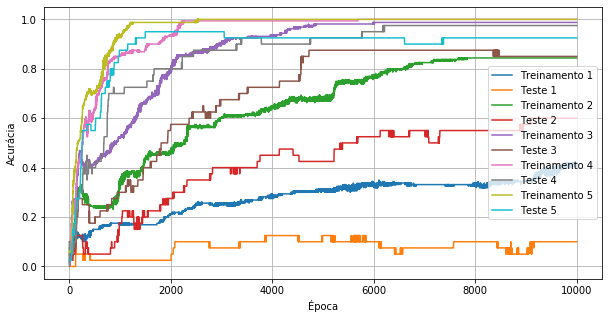

In [28]:
legend = []
for i in range(1,6):
    with open('variacao_neuronios/'+str(i)+'_neurons.pickle', 'rb') as handle:
        history = pickle.load(handle)
        
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    legend = legend + ['Treinamento ' + str(i), 'Teste '+ str(i)]
    
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend(legend, loc='best')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.grid()
plt.show()

In [68]:
directory = 'Dados_continuo3'

dataset = pd.DataFrame()

files_list = os.listdir(directory)
    
stats = []
# all_dataframe = {}

for f in files_list:
    print(len(dataset))
    with open(directory+"/"+f) as file:
        lines = [line.strip() for line in file]
        lines = ast.literal_eval(lines[0])
        test = pd.DataFrame(lines)
#         d = {'media':test.mean(), 'desvio_padrao': test.std(), 'max': test.max(), 'min': test.min()}

#         stats.append(pd.DataFrame(d))
        dataset = dataset.append(test, ignore_index = True)

#         if letra not in all_dataframe:
#             all_dataframe[letra] = []
#         all_dataframe[letra].append(test)
dataset  = dataset/16384

0


In [71]:
dif_df = dataset.diff(axis = 0, periods = 1) 

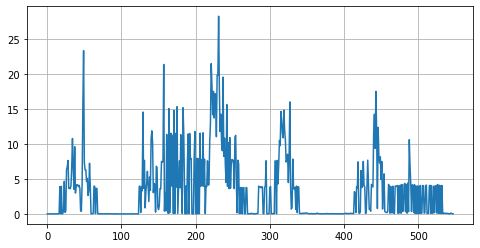

In [80]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(dif_df.iloc[:,:].pow(2).sum(axis=1))
plt.grid()
plt.show()

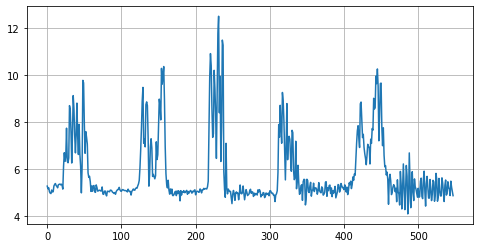

In [81]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(dataset.iloc[:,:].pow(2).sum(axis=1))
plt.grid()
plt.show()

In [82]:
directory = 'Dados_continuo4'

dataset = pd.DataFrame()

files_list = os.listdir(directory)
    
stats = []
# all_dataframe = {}

for f in files_list:
    print(len(dataset))
    with open(directory+"/"+f) as file:
        lines = [line.strip() for line in file]
        lines = ast.literal_eval(lines[0])
        test = pd.DataFrame(lines)
#         d = {'media':test.mean(), 'desvio_padrao': test.std(), 'max': test.max(), 'min': test.min()}

#         stats.append(pd.DataFrame(d))
        dataset = dataset.append(test, ignore_index = True)

#         if letra not in all_dataframe:
#             all_dataframe[letra] = []
#         all_dataframe[letra].append(test)
dataset  = dataset/16384

0


In [83]:
dif_df = dataset.diff(axis = 0, periods = 1) 

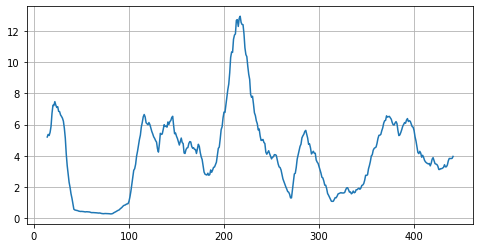

In [100]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(dif_df.iloc[:,:].abs().sum(axis=1).rolling(window=15).mean())
plt.grid()
plt.show()

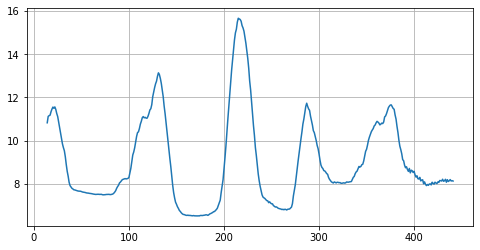

In [98]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(dataset.iloc[:,:].abs().sum(axis=1).rolling(window=15).mean())
plt.grid()
plt.show()

In [152]:
len(prevs)

442

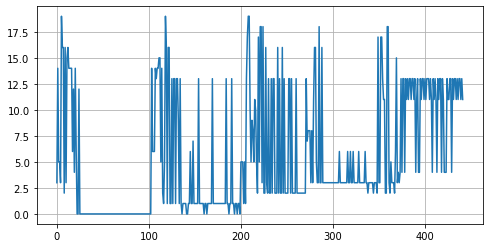

In [156]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(prevs)
plt.grid()
plt.show()

In [101]:
model = load_model('modelo_alfabeto_treinado.h5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [139]:
# errors = get_incorrects(model, X_DT, y_DT)

p = model.predict(dataset)
    
# errors = []
# for i in range(len(data)):
#     equal = (np.where(labels[i] == np.amax(labels[i]))[0][0]) == (np.where(p[i] == np.amax(p[i])))[0][0]
#     if not equal:
#         print((np.where(labels[i] == np.amax(labels[i]))[0][0]), (np.where(p[i] == np.amax(p[i])))[0][0])
#         print()
#         errors.append(i)

# print(len(errors))

In [143]:
prevs = []
for a in range(len(p)):
    prev = np.where(p[a] == np.amax(p[a]))[0][0]
    prevs.append(prev)

In [144]:
prevs

[3,
 14,
 5,
 5,
 3,
 19,
 16,
 16,
 2,
 16,
 3,
 15,
 16,
 14,
 14,
 14,
 14,
 6,
 12,
 4,
 14,
 6,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 6,
 6,
 6,
 14,
 13,
 14,
 14,
 15,
 15,
 5,
 14,
 2,
 1,
 5,
 19,
 16,
 1,
 16,
 16,
 1,
 1,
 13,
 1,
 13,
 13,
 1,
 13,
 13,
 9,
 1,
 13,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 6,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 13,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 13,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 13,
 1,
 1,
 0,
 1,
 1,
 13,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 5,
 5,
 5,
 1,
 5,
 1,
 13,
 17,
 19,
 19,
 10,
 5,
 9,
 8,
 5,
 11,
 10,
 5,
 2,
 17,
 5,
 18,
 18,
 3,
 18,
 2,
 2,
 16,
 3,
 2,
 13,
 2,
 2,
 13,
 2,
 13,
 13,
